In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/Users/brandonmanley/Desktop/PhD/dijet_dsa')
import dsa_mc.dijet as dijet
import random
from IPython.display import display, Math

# setup plotting
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["axes.labelsize"] = 14  
plt.rcParams["xtick.labelsize"] = 12  
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["axes.titlesize"] = 16 
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"
%config InlineBackend.figure_format = 'retina'

In [2]:
dj = dijet.DIJET(3, constrained_moments=True)
dj.load_params('replica_params_pp.csv')
dj.set_params(3)

points = 7
lumi = 100
roots = 95

pT_values = np.linspace(0.5, 10, 20)

space = {
    'y' : [0.05, 0.95],
    'z' : [0.2, 0.5],
    'min Q2' : 5,
    't' : [0.01, 0.04],
    # 'max Q2' : 30
}

data = {}
approxs = ['riemann', 'gauss', 'mc']
for approx in approxs:
    data[approx] = {}
    for weight in ['den', '1', 'cos(phi_Dp)', 'cos(phi_kp)cos(phi_Dp)', 'sin(phi_kp)sin(phi_Dp)']:
        data[approx][weight] = []
    
for pT in pT_values:

    print('pT', pT)
    
    den_riemann = dj.integrated_denominator(pT, roots**2, space, points=20)
    den_gauss = dj.integrated_denominator_approx(pT, roots**2, space, points=10)
    den_mc = dj.integrated_denominator_mc(pT, roots**2, space, points=1000)
    
    data['riemann']['den'].append(den_riemann)
    data['gauss']['den'].append(den_gauss)
    data['mc']['den'].append(den_mc)

    for weight in ['1', 'cos(phi_Dp)', 'cos(phi_kp)cos(phi_Dp)', 'sin(phi_kp)sin(phi_Dp)']:

        num_riemann = dj.integrated_numerator(pT, roots**2, space, weight=weight, points=30)
        num_gauss = dj.integrated_numerator_approx(pT, roots**2, space, weight=weight, points=8)
        num_mc = dj.integrated_numerator_mc(pT, roots**2, space, weight=weight, points=1500)
        
        data['riemann'][weight].append(num_riemann)
        data['gauss'][weight].append(num_gauss)
        data['mc'][weight].append(num_mc)

    np.save('predictions/integral_testing.npy', data, allow_pickle=True)


Using constrained moment parameters
loaded N(r^2, s) data from narr_ymin4.61_ymax14.91_AAMS09.dat
loaded polarized amp data from /Users/brandonmanley/Desktop/PhD/dijet_dsa/dsa_mc/dipoles/d05-rc/
loaded params from replica_params_dis.csv
loaded random moment params from /dipoles/moment_params_dis.csv
loaded replica 3
loaded params from replica_params_pp.csv
loaded random moment params from /dipoles/moment_params_pp.csv
loaded replica 3
pT 0.5
pT 1.0
pT 1.5
pT 2.0
pT 2.5
pT 3.0
pT 3.5
pT 4.0
pT 4.5
pT 5.0
pT 5.5
pT 6.0
pT 6.5
pT 7.0
pT 7.5
pT 8.0
pT 8.5


KeyboardInterrupt: 

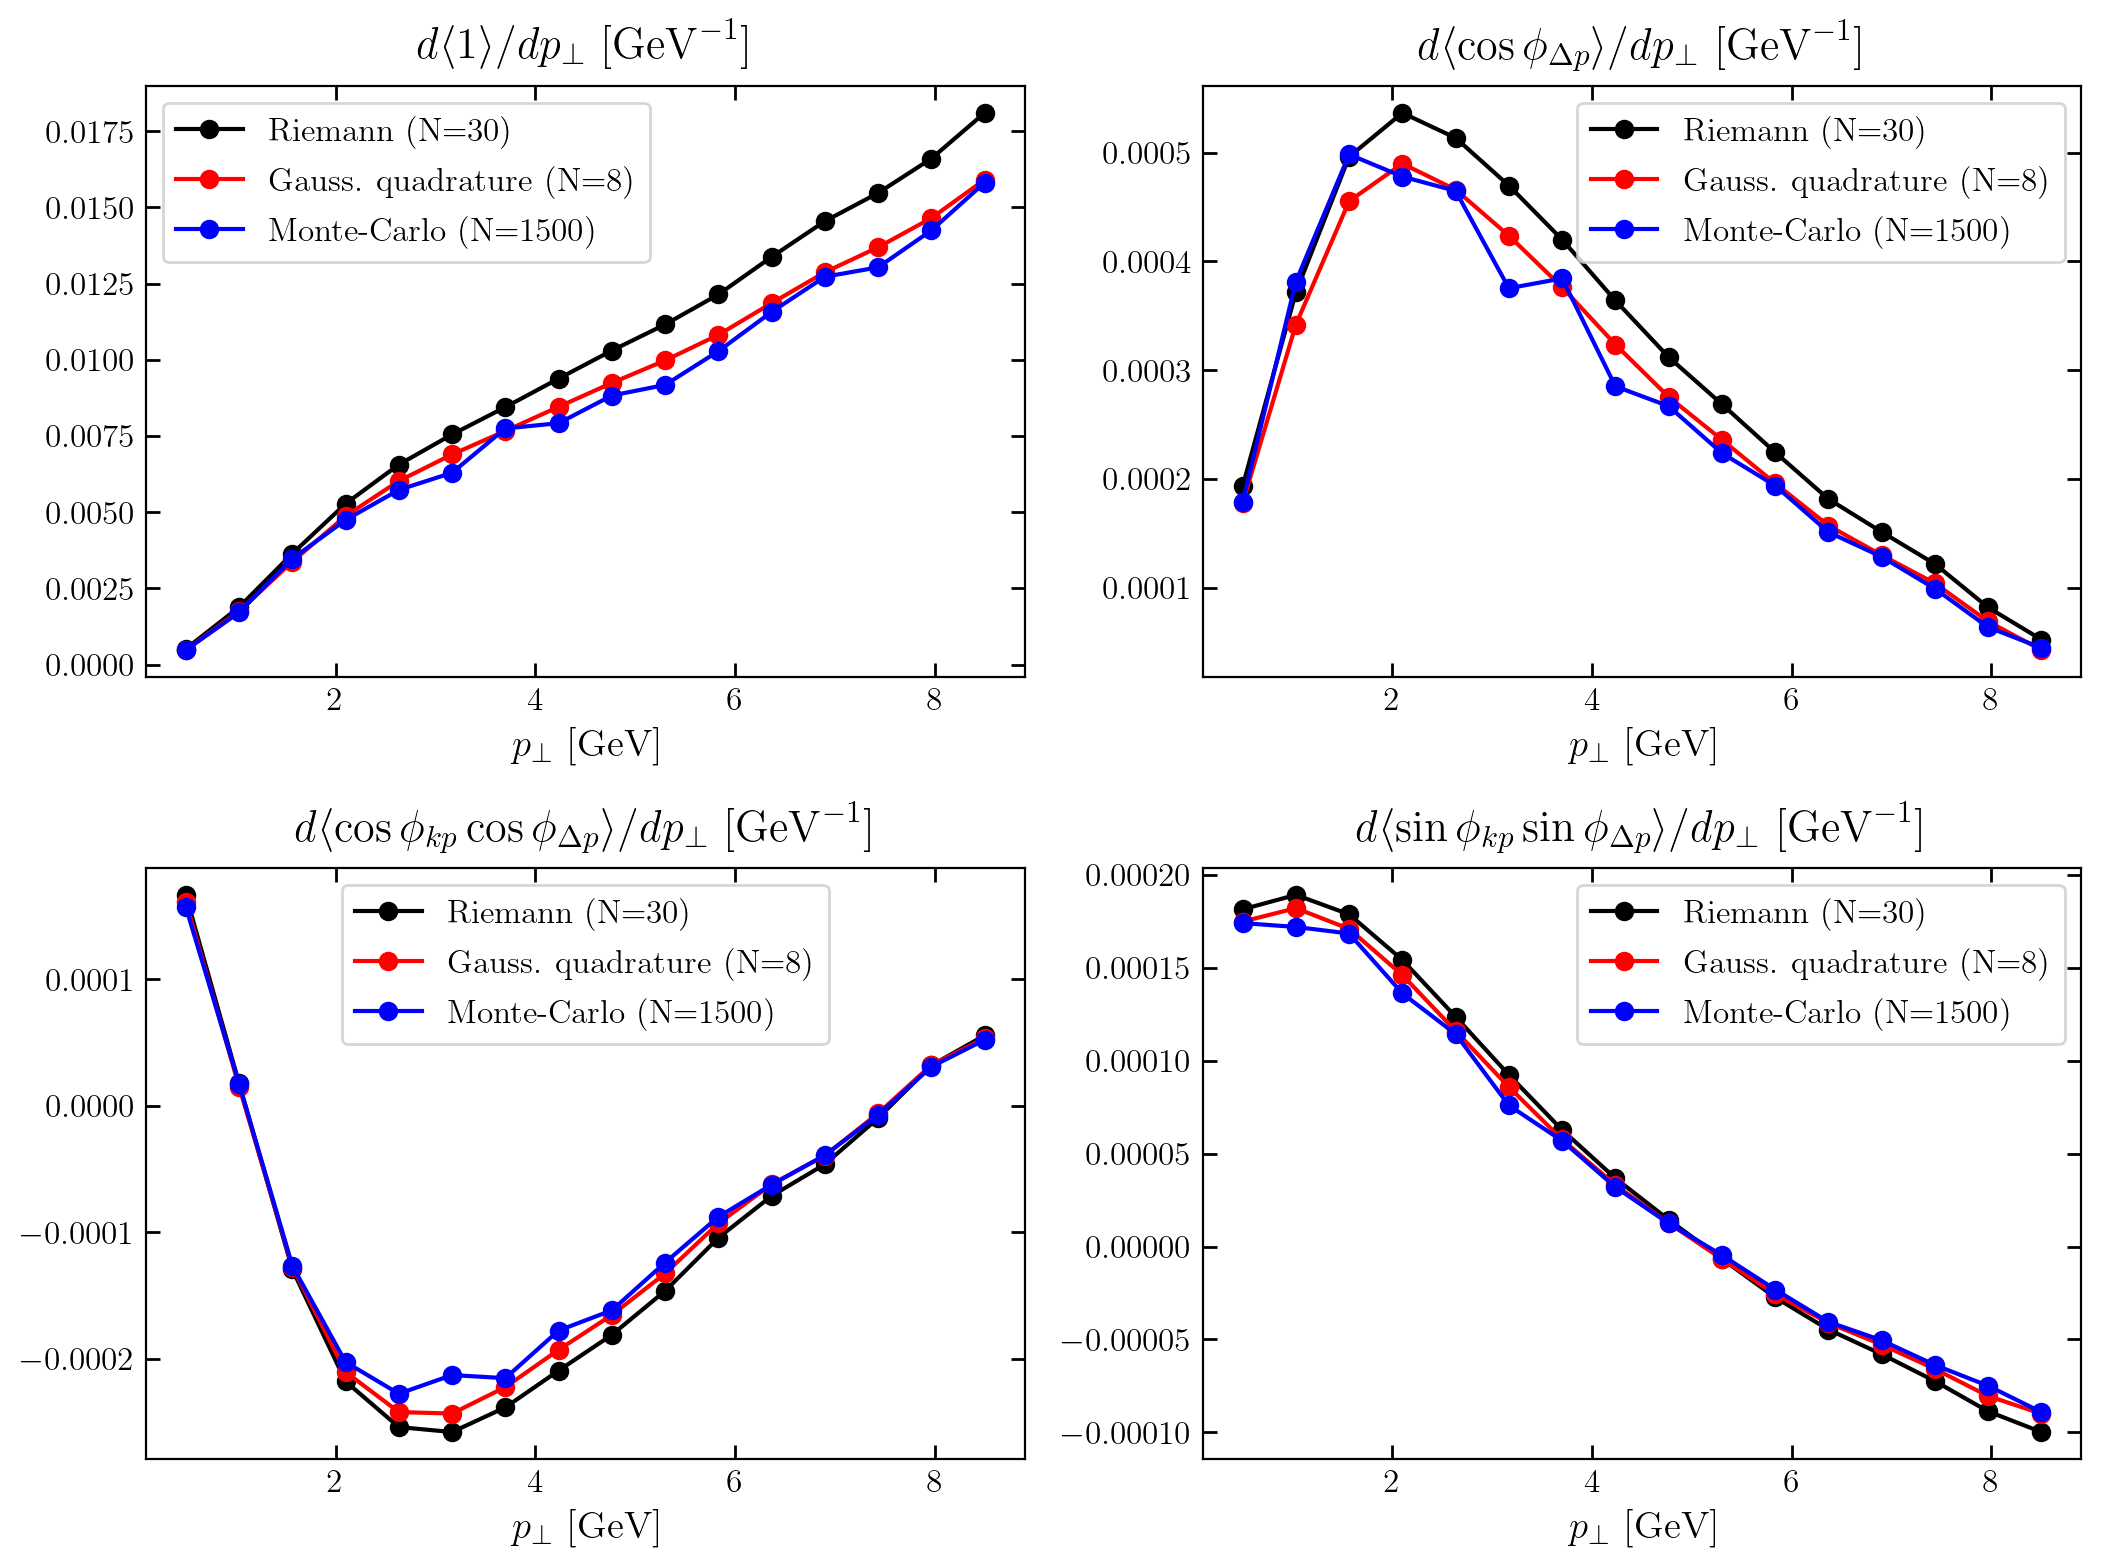

In [48]:
data = np.load('predictions/integral_testing.npy', allow_pickle=True).item()
pT_values = np.linspace(0.5, 8.5, 16) # check to make sure same as above!!

ratio_data = {}
for approx in data:
    ratio_data[approx] = {}
    for weight in data[approx]:
        ratio_data[approx][weight] = np.array(data[approx][weight])/np.array(data[approx]['den'])



asp_ratio = 4/3
psize = 4
fig, ax = plt.subplots(2, 2, figsize=(asp_ratio*psize*2, psize*2))

colors = ['black', 'red', 'blue']
labels = ['Riemann (N=30)', 'Gauss. quadrature (N=8)', 'Monte-Carlo (N=1500)']
axs = [[0,0], [0,1], [1,0], [1,1]]

for i, approx in enumerate(approxs):
    for j, weight in enumerate(data[approx]):
        if weight == 'den': continue
        ax[*axs[j-1]].plot(pT_values, ratio_data[approx][weight], color=colors[i], label=labels[i], marker='o')

for jax in ax:
    for iax in jax:
        iax.tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)
        iax.set_xlabel(r'$p_{\perp}$ [GeV]')
        iax.tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)
        iax.legend()
        # iax.semilogy()

ax[0,0].set_title(r'$d \langle 1 \rangle /d p_\perp \,\,[\mathrm{GeV}^{-1}]$', pad=10)
ax[0,1].set_title(r'$d \langle \cos \phi_{\Delta p}  \rangle /d p_\perp \,\,[\mathrm{GeV}^{-1}]$', pad=10)
ax[1,0].set_title(r'$d \langle \cos \phi_{k p}  \cos \phi_{\Delta p}  \rangle /d p_\perp \,\,[\mathrm{GeV}^{-1}]$', pad=10)
ax[1,1].set_title(r'$d \langle  \sin \phi_{k p}  \sin \phi_{\Delta p}  \rangle /d p_\perp \,\,[\mathrm{GeV}^{-1}]$', pad=10)

plt.tight_layout()
plt.show()

fig.savefig('plots/integrals_corrs.pdf', dpi=700)
